**Note:** In order to run this notebook you have to have the GPU accelerator enabled (see notebook on requesting additional computing resources)

In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it 
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/" 
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


# Natural Language Processing: Deep Learning

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is part of a broader family of machine learning methods based on the layers used in artificial neural networks.  Here is how deep learning fits into the broader AI picture,

<img src="https://upload.wikimedia.org/wikipedia/commons/1/18/AI-ML-DL.png" height='500' width='500'>

# Deep Neural Networks

A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers. The DNN finds the correct mathematical manipulation to turn the input into the output, whether it be a linear relationship or a non-linear relationship. The network moves through the layers calculating the probability of each output. 

DNNs can model complex non-linear relationships. DNN architectures generate compositional models where the object is expressed as a layered composition of primitives. The extra layers enable composition of features from lower layers, potentially modeling complex data with fewer units than a similarly performing shallow network

DNNs are typically feedforward networks in which data flows from the input layer to the output layer without looping back. At first, the DNN creates a map of virtual neurons and assigns random numerical values, or "weights", to connections between them. The weights and inputs are multiplied and return an output between 0 and 1. If the network doed accurately recognize a particular pattern, an algorithm (backpropagation) will adjust the weights appropriately.

<img src='https://i.stack.imgur.com/OH3gI.png' height='250' width='750'>

The difference between ANNs and DNNs is the number of hidden layers in the network.

# NLP and Deep Learning

DNNs are particularly well suited for NLP.  But before we look at this application we need to talk about `word embeddings`.

## From Vector Model to Word Embeddings

### The Vector Model

In the [document vector model](https://en.wikipedia.org/wiki/Vector_space_model) of a collection of documents each word that appears in the collection is defined as a dimension in the corresponding vector model and each document appears as a feature vector in this model.  Consider the following figure,

<!-- ![](https://ahmedbesbes.com/images/article_5/tfidf.jpg) -->

<!-- ![](https://raw.githubusercontent.com/lutzhamel/fake-news/master/term-doc.jpg) -->

<img src="https://raw.githubusercontent.com/lutzhamel/fake-news/master/term-doc.jpg" height="350" width="450">

Here each column represents the feature vector of one of the documents in the collection and the rows are the features or dimensions of the vectors. Notice that there is one feature for each word that appears in the collection of documents. The column vectors can be used for training a text classifier, that is, the transpose of the term-doc matrix shown here can be used directly as a training set for a classifier. 
 
The fields in the term-doc matrix are the counts of how many times a word appears in a document.  However, there are many ways to encode the occurences of words in the collection within this matrix. In the binary `CountVectorizer`  the fields are just 0 and 1 indicating whether a particular word appears in a document or not. Perhaps the most famous encoding is [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf), short for term frequency–inverse document frequency.

### Disadvantages of the Vector Model

The vector representation of documents has two important consequences for document classification problems: 

* The order and contexts of words are lost. To see the importance of the word context consider these [two sentences](https://jair.org/index.php/jair/article/view/11030): “it was not good, it was actually quite bad” and “it was not bad, it was actually quite good”.  The vector representation of these sentences is exactly the same but they obviously have very different meanings or classifications.  The vector representation of  documents is often  called the *bag of words* representation referring to the fact that it loses all order and context information.

In [2]:
# show the vector models of our two sentences
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

doc_names = ["sen1", "sen2"]
docs = ["it was not good, it was actually quite bad",
        "it was not bad, it was actually quite good"]

# process documents
vectorizer = CountVectorizer(analyzer = "word", binary = True)
docarray = vectorizer.fit_transform(docs).toarray()
coords = vectorizer.get_feature_names_out()
docterm = pd.DataFrame(data=docarray,index=doc_names,columns=coords)
print("\nDocterm:")
print(docterm)


Docterm:
      actually  bad  good  it  not  quite  was
sen1         1    1     1   1    1      1    1
sen2         1    1     1   1    1      1    1


*  Semantic similarities between words cannot be represented. To see the importance of semantic similarity consider one document that discusses dogs and another document that discusses puppies. From a vector model perspective the feature set for these two documents will not intersect in terms of the notion of dog because the vector model simply considers dogs and puppies to be two different features and the similarity of these documents will not be apparent to a machine learning algorithm.
```
Docterm:
           ...  dogs  puppies  ...
sen1    ...     1        0  ...
sen2    ...     0        1  ...
```

### Word Embeddings

Here words are represented as [*embedding vectors*](https://en.wikipedia.org/wiki/Word_embedding) with the idea that two words that are semantically similar to each other have similar vectors. Consider the following figure,


 <img src="https://www.researchgate.net/profile/Tom_Kenter/publication/325451970/figure/fig1/AS:632023664304129@1527697592901/Visualization-of-3-dimensional-word-embeddings.png" height="200" width="250"/>

This figure represents a 3D embedding space and we can see that concepts that are similar to each other are close together in this embedding space.  Therefore the similarity of our two documents talking about dogs and puppies is expressed as a "vector simililarity" which is most often computed as the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) rather than comparing features directly,

<img src="http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png" height="200" width="800">

In other words, we are comparing the semantic notion of dogs and puppies rather than the precise syntax of the words.

Here is another example of five embedding vectors in a 2D embedding space,

<img src="https://raw.githubusercontent.com/lutzhamel/word2vec-simplified/master/word-vectors.png">

The five vectors represent the words,

* Red – Queen
* Blue – King
* Green – Man
* Black – Woman
* Yellow – Oil

Applying vector similarity here it becomes obvious that the vectors representing 'Man' and 'Woman' are most similar to each other, that is, they are semantically most closely related.  It is also easy to see that the vector representing 'Oil' is most dissimilar to all the other vectors.

One of the more popular word embeddings is [word2vec](https://en.wikipedia.org/wiki/Word2vec) created by Google which embeds words in a 300D vector space.  Sentences are now represented as a `len x 300` matrix (or tensor in DNN terminology) where `len` is the number of words in the sentence and `300` is the embedding dimension.

A GitHub repository that explores word2vec a little bit further can be found [here](https://github.com/lutzhamel/word2vec-simplified).

## Processing Documents for DNNs

In deep neural networks documents are no longer compressed into a vector representation of just word occurences.  Instead, deep neural networks process actual sequences of words (coded as a integers) as they appear in the documents thereby *maintaining the order and contexts* of words. Consider the following code snippet using the [Keras](https://keras.io) tokenizer applied to our two sentences from above,
 ```python
from keras.preprocessing.text import Tokenizer
tok = Tokenizer()
# train tokenizer
tok.fit_on_texts(["it was not good, it was actually quite bad"])
# print sequences
print(tok.texts_to_sequences(["it was not good, it was actually quite bad"])[0])
print(tok.texts_to_sequences(["it was not bad, it was actually quite good"])[0])
 ```
 This will print out the following sequences,
 ```
[1, 2, 3, 4, 1, 2, 5, 6, 7]
[1, 2, 3, 7, 1, 2, 5, 6, 4]
 ```
 with a `word_index` of,
 ```
 {'it': 1, 'was': 2, 'not': 3, 'good': 4, 'actually': 5, 'quite': 6, 'bad': 7}
```
These sequences can be directly fed into a deep neural network for training and classification. Notice that word order and context are nicely preserved in this representation.  This is very different from the Naive Bayes training from our previous NLP applications.

# A Deep Neural Network for Fake-News

The deep neural network we are using for our experiment can be seen here as a Python implementation using the [Keras](https://keras.io) deep learning library,

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TEXT_DATA = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

Get our text data and preprocess it,

In [4]:
# read in our data and preprocess it
df = pd.read_csv(TEXT_DATA)
print(df.head())

# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

      id  ... label
0   8476  ...  FAKE
1  10294  ...  FAKE
2   3608  ...  REAL
3  10142  ...  FAKE
4    875  ...  REAL

[5 rows x 4 columns]


In [5]:
# prepare text samples and their labels
texts = df['text']
labels = df['label']
print('Found {} texts.'.format(texts.shape[0]))

Found 6335 texts.


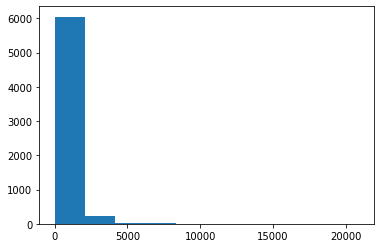

In [6]:
# plot the distribution of article lengths in terms of word counts
text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

From the graph above we see that the majority of documents have 5000 words or less.  Therefore we pick the constant `MAX_SEQUENCE_LENGTH` to be 5000.

In [7]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

In [8]:
# a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [9]:
# a function estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [10]:
# vectorize the text samples into a 2D integer tensor 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [11]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT,
                                                  random_state=0)

In [12]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Our DNN can be broken down into two distinct parts. The first part consists of three layers and is responsible for  word and sequence processing:
1. The Embedding layer - learn word embeddings.
2. The Convolution layer - learn patterns throughout the text sequences.
3. The Pooling layer - filter out the interesting sequence patterns.

The second part consists of two layers,

1. A Dense layer with a ReLU activation function.
2. A Dense layer (also the output layer) with a Sigmoid activation function.

This part of the DNN can be viewed as a traditional feed-foward, back-propagation neural network with one hidden layer operating on a feature vector of length 128 computed by the first part of the DNN.   In order to see this perhaps a bit clearer, look at the summary of the DNN as compiled by Keras,



In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 300)         7500300   
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
______________________________________________

The `None` in the *Output Shape* column simply denotes the *current batch size default*. That  means the pooling layer computes a feature vector of size 128 which is passed into dense layers of the feedforward network as we mentioned above.

The overall structure of the DNN can be understood as a preprocessor defined in the first part that is being trained to map text sequences into feature vectors in such a way that the weights of the second part can be trained to obtain optimal classification results from the overall network. 

In [14]:
# train the model

history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 30s 654ms/step - loss: 0.4729 - accuracy: 0.7861 - val_loss: 0.2290 - val_accuracy: 0.9148
Epoch 2/10
40/40 [==============================] - 24s 600ms/step - loss: 0.1295 - accuracy: 0.9647 - val_loss: 0.1122 - val_accuracy: 0.9669
Epoch 3/10
40/40 [==============================] - 24s 599ms/step - loss: 0.0327 - accuracy: 0.9939 - val_loss: 0.0829 - val_accuracy: 0.9740
Epoch 4/10
40/40 [==============================] - 24s 599ms/step - loss: 0.0062 - accuracy: 0.9998 - val_loss: 0.0789 - val_accuracy: 0.9684
Epoch 5/10
40/40 [==============================] - 24s 598ms/step - loss: 9.1464e-04 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 0.9740
Epoch 6/10
40/40 [==============================] - 24s 599ms/step - loss: 1.8172e-04 - accuracy: 1.0000 - val_loss: 0.0852 - val_accuracy: 0.9724
Epoch 7/10
40/40 [==============================] - 24s 599ms/step - loss: 2.2681e-05 - accuracy: 1.0000 - val_loss: 0.0956 - val_accu

In [15]:
# all possible parameters history stores
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

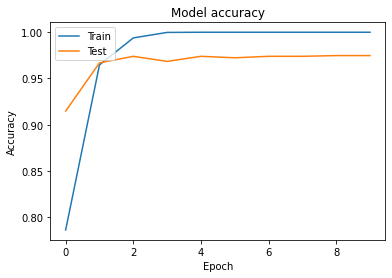

In [16]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# evaluate model

train_acc, test_acc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 100.00%
Testing Accuracy: 97.47%


In [18]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 96.61%-98.34%
